Merge 25 CSVs + Summaries + Plots + GLMM


In [1]:
!pip -q install pandas numpy matplotlib statsmodels

import io, os, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


# 1) Load & Merge (25 files)

BASE_URL = "https://raw.githubusercontent.com/PON2020/vast/main"
LETTERS  = ["A", "B", "C", "D", "E"]
NUMBERS  = [1, 2, 3, 4, 5]

dfs = []
failed = []

for L in LETTERS:
    for N in NUMBERS:
        fname = f"Model_{L}_{N}.csv.csv"
        url = f"{BASE_URL}/{fname}"
        try:
            df = pd.read_csv(url)
            df["source_file"] = fname
            # normalize column names (in case of stray whitespace/case)
            df.columns = [c.strip() for c in df.columns]
            # keep only relevant cols if more exist
            assert {"image_index","accuracy","model","prompt"}.issubset(df.columns), \
                f"Missing required cols in {fname}: {set(['image_index','accuracy','model','prompt']) - set(df.columns)}"
            dfs.append(df)
            print(f"Loaded: {fname}  ({len(df)} rows)")
        except Exception as e:
            print(f"!! Failed: {fname} → {e}")
            failed.append((fname, str(e)))

if not dfs:
    raise RuntimeError("No files loaded. Check BASE_URL and filenames.")

data = pd.concat(dfs, ignore_index=True)
print("\nMerged shape:", data.shape)




Loaded: Model_A_1.csv.csv  (50 rows)
Loaded: Model_A_2.csv.csv  (50 rows)
Loaded: Model_A_3.csv.csv  (50 rows)
Loaded: Model_A_4.csv.csv  (50 rows)
Loaded: Model_A_5.csv.csv  (50 rows)
Loaded: Model_B_1.csv.csv  (50 rows)
Loaded: Model_B_2.csv.csv  (50 rows)
Loaded: Model_B_3.csv.csv  (50 rows)
Loaded: Model_B_4.csv.csv  (50 rows)
Loaded: Model_B_5.csv.csv  (50 rows)
Loaded: Model_C_1.csv.csv  (50 rows)
Loaded: Model_C_2.csv.csv  (50 rows)
Loaded: Model_C_3.csv.csv  (50 rows)
Loaded: Model_C_4.csv.csv  (50 rows)
Loaded: Model_C_5.csv.csv  (50 rows)
Loaded: Model_D_1.csv.csv  (50 rows)
Loaded: Model_D_2.csv.csv  (50 rows)
Loaded: Model_D_3.csv.csv  (50 rows)
Loaded: Model_D_4.csv.csv  (50 rows)
Loaded: Model_D_5.csv.csv  (50 rows)
Loaded: Model_E_1.csv.csv  (50 rows)
Loaded: Model_E_2.csv.csv  (50 rows)
Loaded: Model_E_3.csv.csv  (50 rows)
Loaded: Model_E_4.csv.csv  (50 rows)
Loaded: Model_E_5.csv.csv  (50 rows)

Merged shape: (1250, 20)


In [2]:

# 2) Clean & Prepare
# accuracy: map T/F strings → 1/0
# Normalize accuracy column (string, strip spaces, uppercase)
data["accuracy"] = data["accuracy"].astype(str).str.strip().str.upper()

# Map common values to binary
truthy = {"T", "TRUE", "1", "YES", "Y", "CORRECT"}
falsey = {"F", "FALSE", "0", "NO", "N", "INCORRECT"}

data["acc_bin"] = None
data.loc[data["accuracy"].isin(truthy), "acc_bin"] = 1
data.loc[data["accuracy"].isin(falsey), "acc_bin"] = 0

# Drop rows with unknown accuracy values
unknown_vals = set(data["accuracy"]) - truthy - falsey
if unknown_vals:
    print("Warning: Unrecognized accuracy values found:", unknown_vals)

data = data.dropna(subset=["acc_bin"])

# Safe cast to int
data["acc_bin"] = data["acc_bin"].astype(int)


# coerce types/labels
data["model"]  = data["model"].astype(str).str.strip()
data["prompt"] = data["prompt"].astype(str).str.strip()
# image_index could be numeric or string ID; keep as string for grouping
data["image_index"] = data["image_index"].astype(str).str.strip()

# Save merged dataset (optional)
merged_path = "all_models_prompts_merged.csv"
data.to_csv(merged_path, index=False)
print(f"Saved merged dataset → {merged_path}")


Saved merged dataset → all_models_prompts_merged.csv


In [3]:
# 3) Summary Accuracy Tables

def pct(x):
    return 100 * x.mean()

overall_acc = data["acc_bin"].mean()
by_model    = data.groupby("model")["acc_bin"].agg(["count","mean"])
by_prompt   = data.groupby("prompt")["acc_bin"].agg(["count","mean"])
by_mp       = data.groupby(["model","prompt"])["acc_bin"].agg(["count","mean"]).reset_index()

print("\n=== Overall accuracy ===")
print(f"{overall_acc:.3f}  ({overall_acc*100:.1f}%)")

print("\n=== Accuracy by model ===")
print(by_model.rename(columns={"mean":"accuracy"}).assign(accuracy=lambda d: d["accuracy"].round(3)))

print("\n=== Accuracy by prompt ===")
print(by_prompt.rename(columns={"mean":"accuracy"}).assign(accuracy=lambda d: d["accuracy"].round(3)))

print("\n=== Accuracy by model × prompt ===")
print(by_mp.rename(columns={"mean":"accuracy"}).assign(accuracy=lambda d: d["accuracy"].round(3)))

# Export summary tables
by_model.to_csv("summary_by_model.csv")
by_prompt.to_csv("summary_by_prompt.csv")
by_mp.to_csv("summary_by_model_prompt.csv", index=False)





=== Overall accuracy ===
0.495  (49.5%)

=== Accuracy by model ===
       count  accuracy
model                 
A        210     0.538
B        241     0.481
C        250     0.468
D        241     0.452
E        238     0.542

=== Accuracy by prompt ===
        count  accuracy
prompt                 
1         238     0.496
2         238     0.487
3         235     0.506
4         233     0.476
5         236     0.508

=== Accuracy by model × prompt ===
   model prompt  count  accuracy
0      A      1     42     0.357
1      A      2     47     0.511
2      A      3     41     0.634
3      A      4     43     0.581
4      A      5     37     0.622
5      B      1     49     0.531
6      B      2     50     0.440
7      B      3     49     0.408
8      B      4     44     0.455
9      B      5     49     0.571
10     C      1     50     0.520
11     C      2     50     0.460
12     C      3     50     0.460
13     C      4     50     0.460
14     C      5     50     0.440
15     D   

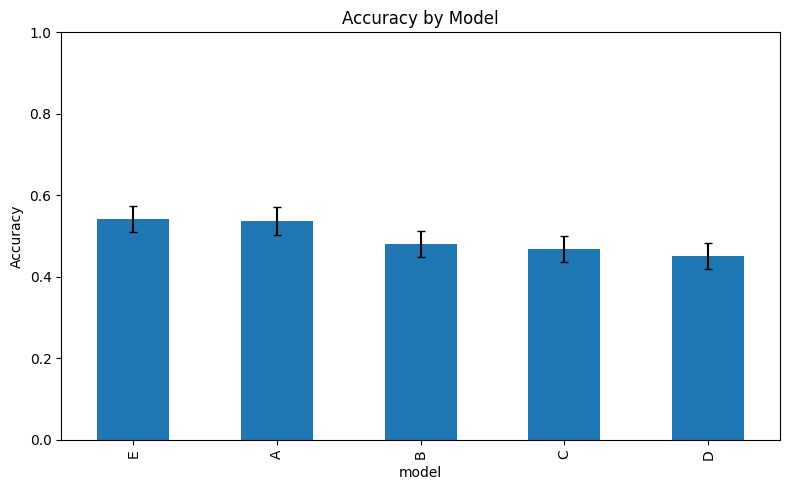

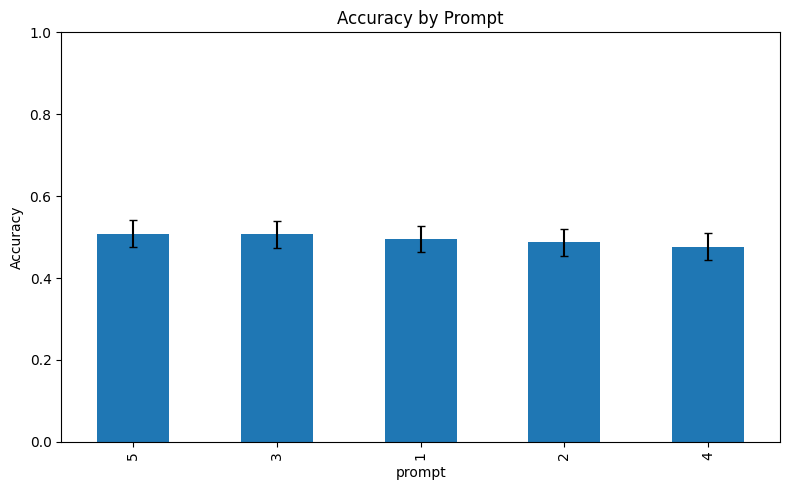

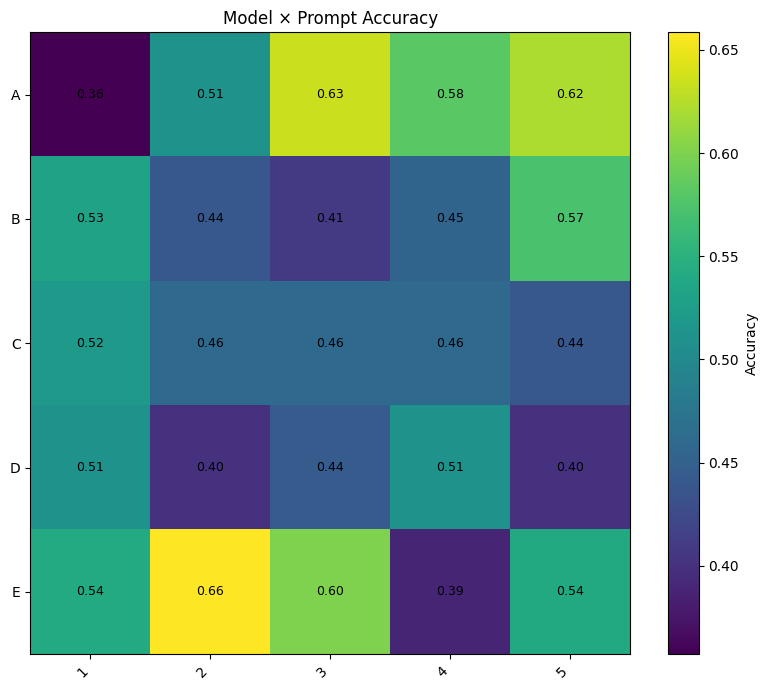

In [4]:
# 4) Model × Prompt Interaction Plots
# (a) Bar plot: accuracy by model (with simple error bars: binomial SE)
model_means = data.groupby("model")["acc_bin"].mean()
model_counts = data.groupby("model")["acc_bin"].count()
model_se = np.sqrt(model_means*(1-model_means)/model_counts)

plt.figure(figsize=(8, 5))
model_means.sort_values(ascending=False).plot(kind="bar", yerr=model_se.loc[model_means.sort_values(ascending=False).index], capsize=3)
plt.ylabel("Accuracy")
plt.title("Accuracy by Model")
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("plot_accuracy_by_model.png", dpi=150)
plt.show()

# (b) Bar plot: accuracy by prompt
prompt_means = data.groupby("prompt")["acc_bin"].mean()
prompt_counts = data.groupby("prompt")["acc_bin"].count()
prompt_se = np.sqrt(prompt_means*(1-prompt_means)/prompt_counts)

plt.figure(figsize=(8, 5))
prompt_means.sort_values(ascending=False).plot(kind="bar", yerr=prompt_se.loc[prompt_means.sort_values(ascending=False).index], capsize=3)
plt.ylabel("Accuracy")
plt.title("Accuracy by Prompt")
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("plot_accuracy_by_prompt.png", dpi=150)
plt.show()

# (c) Heatmap: Model × Prompt accuracy
# Using matplotlib only (no seaborn)
mp_matrix = data.pivot_table(index="model", columns="prompt", values="acc_bin", aggfunc="mean")
plt.figure(figsize=(1.2*len(mp_matrix.columns)+2, 1.0*len(mp_matrix.index)+2))
plt.imshow(mp_matrix.values, aspect="auto")
plt.colorbar(label="Accuracy")
plt.xticks(ticks=np.arange(len(mp_matrix.columns)), labels=mp_matrix.columns, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(mp_matrix.index)), labels=mp_matrix.index)
plt.title("Model × Prompt Accuracy")
# annotate cells
for i in range(mp_matrix.shape[0]):
    for j in range(mp_matrix.shape[1]):
        val = mp_matrix.values[i, j]
        if not np.isnan(val):
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9)
plt.tight_layout()
plt.savefig("plot_model_prompt_heatmap.png", dpi=150)
plt.show()



In [5]:
# 5) Mixed-Effects Logistic Regression
#     - Fixed: model, prompt
#     - Random intercept: image_index

from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

# Build formula-style model:
#   acc_bin ~ C(model) * C(prompt)
#   Random intercept per image_index via variance components formula (0 + C(image_index))
# Note: BinomialBayesMixedGLM uses a Bayesian approach (variational Bayes / Laplace approx).
#       The results include approximate posterior means and std. errors of fixed effects
#       and variance components.

# To avoid singularities, set a reference level for model/prompt automatically via patsy coding
data_glmm = data.copy()

# Variance component: random intercept per image_index
vcf = {"img": "0 + C(image_index)"}

print("\nFitting mixed-effects logistic regression (this may take a bit)...")
glmm = BinomialBayesMixedGLM.from_formula(
    "acc_bin ~ C(model) * C(prompt)",
    vcf,
    data_glmm
)
glmm_res = glmm.fit_vb()  # variational Bayes fit (fast & robust for larger VC design)
print("\n=== Mixed-Effects Logistic Regression (Binomial, random intercept per image) ===")
print(glmm_res.summary())

# Save model summary to text
with open("glmm_results.txt", "w") as f:
    f.write(glmm_res.summary().as_text())

print("\nArtifacts saved:")
print(" - all_models_prompts_merged.csv")
print(" - summary_by_model.csv")
print(" - summary_by_prompt.csv")
print(" - summary_by_model_prompt.csv")
print(" - plot_accuracy_by_model.png")
print(" - plot_accuracy_by_prompt.png")
print(" - plot_model_prompt_heatmap.png")
print(" - glmm_results.txt")


Fitting mixed-effects logistic regression (this may take a bit)...

=== Mixed-Effects Logistic Regression (Binomial, random intercept per image) ===
                        Binomial Mixed GLM Results
                             Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
---------------------------------------------------------------------------
Intercept                       M    -0.2468   0.0604                      
C(model)[T.B]                   M     0.3170   0.1334                      
C(model)[T.C]                   M     0.2656   0.1304                      
C(model)[T.D]                   M     0.2294   0.1335                      
C(model)[T.E]                   M     0.3787   0.1358                      
C(prompt)[T.2]                  M     0.2709   0.1351                      
C(prompt)[T.3]                  M     0.7214   0.1359                      
C(prompt)[T.4]                  M     0.5151   0.1357                      
C(prompt)[T.5]                  M     0

In [7]:


# 6) Mixed-Effects Logistic Regression
#     - Fixed: model, prompt
#     - Random intercept: image_index
#     - Then derive Wald z, p, and 95% CIs for fixed effects

from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
from scipy import stats

data_glmm = data.copy()
vcf = {"img": "0 + C(image_index)"}

print("\nFitting mixed-effects logistic regression (this may take a bit)...")
glmm = BinomialBayesMixedGLM.from_formula(
    "acc_bin ~ C(model) * C(prompt)",
    vcf,
    data_glmm
)
glmm_res = glmm.fit_vb()  # variational Bayes fit (fast)

print("\n=== Mixed-Effects Logistic Regression (Binomial, random intercept per image) ===")
print(glmm_res.summary())

# Note: Using posterior mean and sd as if they were MLE estimates to compute Wald stats.
# This is a pragmatic approximation (common in practice with this fitter).
if hasattr(glmm_res, "fe_mean") and hasattr(glmm_res, "fe_sd"):
    coef = pd.Series(glmm_res.fe_mean, index=glmm.exog_names, name="coef")
    se   = pd.Series(glmm_res.fe_sd,   index=glmm.exog_names, name="se")
else:
    # Fallback (unlikely): try params and a diagonal from cov if available
    params = pd.Series(glmm_res.params[:len(glmm.exog_names)], index=glmm.exog_names)
    try:
        cov = glmm_res.cov_params()  # may not exist for VB
        se  = pd.Series(np.sqrt(np.diag(cov))[:len(glmm.exog_names)], index=glmm.exog_names)
    except Exception:
        raise RuntimeError("Cannot extract standard errors for fixed effects.")
    coef = params

z = coef / se
p = 2 * (1 - stats.norm.cdf(np.abs(z)))
ci_low  = coef - 1.96 * se
ci_high = coef + 1.96 * se

wald_table = pd.DataFrame({
    "coef": coef,
    "se":   se,
    "z":    z,
    "p":    p,
    "ci_low":  ci_low,
    "ci_high": ci_high
})

print("\n=== Fixed Effects: Wald tests (approx.) ===")
print(wald_table)

wald_table.to_csv("glmm_fixed_effects_wald.csv")

# Also save the random-effect SD estimate shown in summary (already printed),
# but we extract VC means/SDs for completeness if available.
if hasattr(glmm_res, "vcp_mean") and hasattr(glmm_res, "vcp_sd"):
    vc_names = ["img_log_sd"]  # BinomialBayesMixedGLM parameterizes variance as log(sd)
    vc = pd.DataFrame({
        "post_mean": glmm_res.vcp_mean,
        "post_sd":   glmm_res.vcp_sd
    }, index=vc_names)
    vc.to_csv("glmm_variance_components.csv")

print("\nArtifacts saved:")
print(" - all_models_prompts_merged.csv")
print(" - summary_by_model.csv")
print(" - summary_by_prompt.csv")
print(" - summary_by_model_prompt.csv")
print(" - plot_accuracy_by_model.png")
print(" - plot_accuracy_by_prompt.png")
print(" - plot_model_prompt_heatmap.png")
print(" - glmm_results.txt (from previous run if you keep it) / and 'glmm_fixed_effects_wald.csv'")



Fitting mixed-effects logistic regression (this may take a bit)...

=== Mixed-Effects Logistic Regression (Binomial, random intercept per image) ===
                        Binomial Mixed GLM Results
                             Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
---------------------------------------------------------------------------
Intercept                       M    -0.2468   0.0604                      
C(model)[T.B]                   M     0.3170   0.1334                      
C(model)[T.C]                   M     0.2656   0.1304                      
C(model)[T.D]                   M     0.2294   0.1335                      
C(model)[T.E]                   M     0.3787   0.1358                      
C(prompt)[T.2]                  M     0.2709   0.1351                      
C(prompt)[T.3]                  M     0.7214   0.1359                      
C(prompt)[T.4]                  M     0.5151   0.1357                      
C(prompt)[T.5]                  M     0